In [41]:
from typing import TypeAlias
import math

import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [42]:
Sample: TypeAlias = list[int | float]
Data: TypeAlias = list[Sample]

Target: TypeAlias = int | float
Targets: TypeAlias = list[Target]

Weights: TypeAlias = list[list[float]]

In [43]:
# Activation functions

from abc import ABC, abstractmethod


class ActivationBase(ABC):
    @abstractmethod
    def calc(self, x: Sample) -> list[float]:
        """Apply the activation function to an layer output"""
        pass

    @abstractmethod
    def derivative(self, x: Sample):
        pass

#######################################


class ReLU(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return np.maximum(0, x)

    def derivative(self, x: Sample):
        return self.calc(x=x)


class Sigmoid(ActivationBase):
    def calc(self, x: Sample) -> list[float]:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: Sample):
        return x * (1-x)

In [190]:
# Loss functions


class LossBase(ABC):
    @abstractmethod
    def calc(self, x: Sample, y: Target) -> float:
        """Apply the loss function to an output layer"""
        pass


class MSELoss(LossBase):
    """For regression""" 
    def calc(self, x: Sample, y: Target) -> float:
        loss = (x - y) ** 2

        # return np.mean(loss)
        return loss


In [45]:
a = [1, 100, 22, 99]

f = Softmax()

b = f.calc(a)
print(b)
print(sum(b))

[7.39262147e-44 7.31058579e-01 9.74950551e-35 2.68941421e-01]
1.0


In [46]:
class Dataset:
    def __init__(self, data: Data, targets: Targets) -> None:
        self.data: Data = data
        self._len = len(data)
        self.targets: Targets = targets

    def __len__(self) -> int:
        return self._len
    
    def __getitem__(self, index) -> Sample:
        return self.data[index]
    
    def __iter__(self):
        return iter(self.data)


In [52]:
class Linear:
    def __init__(self, n_inputs: int, n_neurons: int, activation: ActivationBase = None) -> None:
        self.n_inputs = n_inputs
        self.n_neurons = n_neurons
        
        self.weights = self._init_weights()
        self.bias = self._init_bias()
        self.output = []

        self.activation = activation
    
    def _init_weights(self) -> list[float]:
        weights = np.random.randn(self.n_neurons, self.n_inputs) * 0.1
        return weights
    
    def _init_bias(self) -> list[float]:
        return np.random.randn(1)[0]
    
    def forward(self, inputs) -> None:
        output = np.dot(self.weights, inputs)
        output += self.bias
        
        if self.activation:
            self.output = self.activation.calc(output)
        else:
            self.output = output


Layers: TypeAlias = list[Linear]

In [264]:
class Model:
    def __init__(self, layers: Layers, loss: LossBase):
        self.layers = layers
        self._layers_len = len(layers)
        self.loss = loss
    
    def fit(self, dataset: Dataset, n_epoch: int = 1, learning_rate: float = 0.01, verbose: bool = True) -> list[float]:
        losses_by_epoch = []

        range_epoch = range(n_epoch)
        if verbose:
            range_epoch = tqdm(range_epoch, desc="epochs", position=0)

        for epoch in range_epoch:
            epoch_losses = []

            for i,sample in enumerate(dataset):
                sample = np.array(sample)

                # Forward pass
                self.layers[0].forward(inputs=sample) # input layer
                for j in range(1, self._layers_len):
                    self.layers[j].forward(inputs=self.layers[j-1].output)

                target = dataset.targets[i]


                # Calc loss
                output_error = self.calc_loss(target=target)
                epoch_losses.append(output_error)

                # Backward pass
                D = []
                delta = output_error
                D.append(delta)
                for i in range(self._layers_len - 2, -1, -1):
                    delta = np.dot(self.layers[i].weights, D[-1][0][0])
                    delta *= self.layers[i].activation.derivative(self.layers[i].output)
                    D.append(delta)
                
                # Update weights
                D = D[::-1]
                for i in range(self._layers_len):
                    self.layers[i].weights += np.dot(D[i][0][0], self.layers[i].output) * learning_rate

            mean_loss = np.mean(epoch_losses)
            losses_by_epoch.append(mean_loss)
        
        return losses_by_epoch
    
    def predict(self, sample: Sample) -> list[float]:
        sample = np.array(sample)

        self.layers[0].forward(inputs=sample)
                
        for i in range(1, self._layers_len):
            self.layers[i].forward(inputs=self.layers[i-1].output)
        
        predict = self.layers[-1].output
        return predict
    
    def calc_loss(self, target: Target) -> float:
        output_layer = self.layers[-1]
        output = output_layer.output

        loss = self.loss.calc(x=output, y=target)
        return loss

    
    def set_weights(self, weights: Weights) -> None:
        for w,layer in zip(weights, self.layers):
            layer.weights = w

    @property
    def weights(self) -> Weights:
        weights = [layer.weights for layer in self.layers]
        return weights

## Dataset

In [198]:
X = sorted(np.random.uniform(0, 10, 500))
y = [math.cos(x) for x in X]

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8)

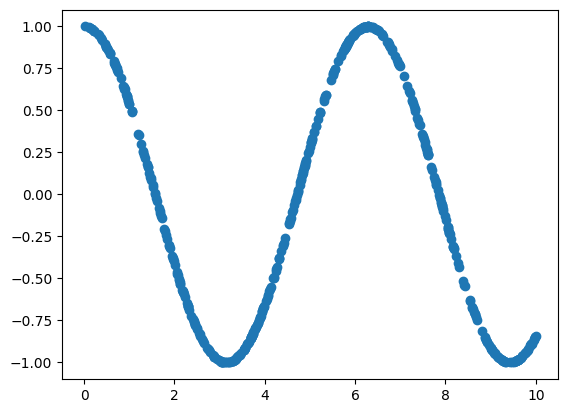

In [199]:
plt.plot(X, y, 'o')
plt.show()

In [282]:
train_dataset = Dataset(data=X_train, targets=y_train)

layers = [
    Linear(1,100, activation=Sigmoid()),
    Linear(100,20, activation=Sigmoid()),
    Linear(20,1),
]

model = Model(layers=layers, loss=MSELoss())


losses = model.fit(dataset=train_dataset, n_epoch=100, learning_rate=0.01, verbose=1)

epochs: 100%|██████████| 100/100 [00:02<00:00, 37.94it/s]


In [283]:
losses

[19.522252823732437,
 0.9911294283347458,
 0.9913674283262504,
 0.991605627279763,
 0.9918440254415044,
 0.9920826230581077,
 0.9923214203766129,
 0.9925604176444733,
 0.9927996151095526,
 0.9930390130201298,
 0.9932786116248932,
 0.9935184111729494,
 0.9937584119138202,
 0.993998614097445,
 0.9942390179741781,
 0.9944796237947944,
 0.9947204318104846,
 0.9949614422728592,
 0.9952026554339523,
 0.9954440715462191,
 0.9956856908625349,
 0.995927513636198,
 0.9961695401209361,
 0.9964117705709008,
 0.9966542052406667,
 0.9968968443852383,
 0.9971396882600431,
 0.9973827371209408,
 0.9976259912242234,
 0.9978694508266099,
 0.9981131161852539,
 0.9983569875577359,
 0.9986010652020767,
 0.9988453493767276,
 0.9990898403405751,
 0.9993345383529387,
 0.9995794436735789,
 0.9998245565626946,
 1.0000698772809238,
 1.0003154060893427,
 1.0005611432494659,
 1.0008070890232534,
 1.0010532436731077,
 1.0012996074618734,
 1.0015461806528412,
 1.0017929635097413,
 1.0020399562967572,
 1.0022871592785

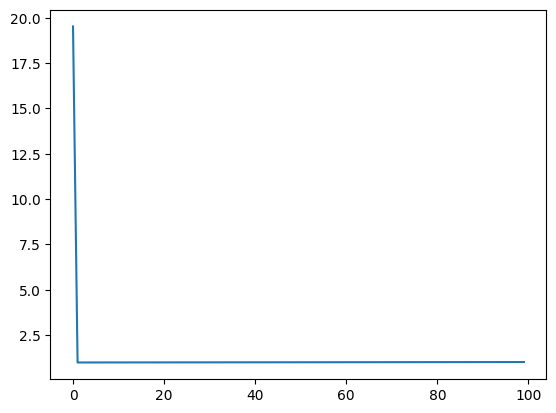

In [284]:
plt.plot(losses)
plt.show()

In [285]:
preds = []
for i in X_val:
    pred = model.predict(i)[0][0]
    preds.append(pred)

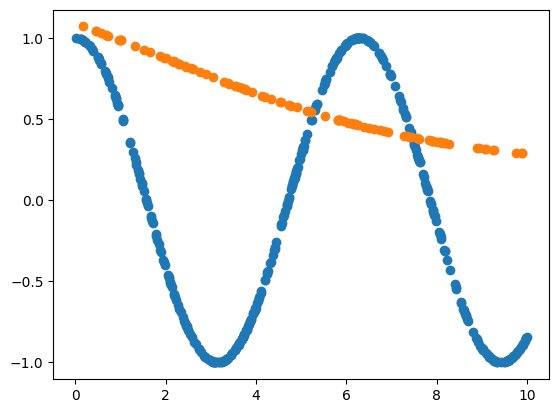

In [286]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_val, preds, 'o')
plt.show()